# Dataloaders using Medicaltorch

In this notebook we are going to explore a medical imaging open-source library known as [MedicalTorch](https://github.com/perone/medicaltorch), which was built on top of PyTorch. 

The purpose of this tutorial is how to create a DataLoader using medicaltorch for medical dataset containing data in NIFTI format. For the purpose of this we will be using the Cardiac MRI dataset.

The Dataset is available as a part of pastly held [MedicalDecathlon](http://medicaldecathlon.com) and can be downloaded from [here](https://goo.gl/QzVZcm)


This tutorial assumes you have installed the medicaltorch library. If you haven't please take a look at [this](https://colab.research.google.com/drive/1V516_8lzebSPw_ygZhJQLfbGedMDikPc#scrollTo=bh8sG3huKAK_) notebook

## Importing Libraries and Let's Get Started!
Let's import the necessary libraries includinf the utility functions from the `medicaltorch` library.

In [1]:
import numpy as np
import os

from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\mohit\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data Exploration
Before we do any modeling stuff, let's investigate our data first. Let's look at one sample (MRI image) from the dataset. 

We will see the preprocessing module `mt_datasets.SegmentationPair2D` which is used to read and format the data in a way that we can better explore it in our environment. See the example below.

In [2]:
ROOT_DIR = "../Datasets/Task02_Heart/"
mri_input_filename = os.path.join(ROOT_DIR,'imagesTr',
                                          'la_004.nii.gz')
mri_gt_filename = "../Datasets/Task02_Heart/labelsTr/la_004.nii.gz"

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(55)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

In [4]:
print(input_slice.shape)

(320, 320)


As you can see above, images are 320 X 320 dimensions. We can also view the image in our environment using matplotlib.

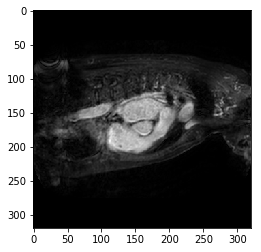

In [5]:
img = input_slice
plt.imshow(img,cmap = 'gray')
plt.show()

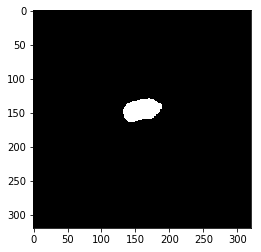

In [6]:
img = gt_slice
plt.imshow(img,cmap = 'gray')
plt.show()

The SegmentationPair2D class gives us a easy-to use wrapper for Analyzing the NIFTI images and thier corresponding segmentation mask.

The 2 most frequently used methods are

`get_pair_slice` - This method is used to fetch a particular slice from the NIFT image. We can also pass the desired axis (Axial,coronal,Sagittal) to view the image

`get_pair_data`- This method is used to fetch the entire image/pixel data and gives us a tuple containing image and mask data


In [7]:
img_data,seg_data = pair.get_pair_data()

In [8]:
img_data.shape

(320, 320, 110)

In [9]:
seg_data.shape

(320, 320, 110)

As you can see we got the entire image and label tensor by using the `get_pair_data` method

## Creating a Dataset for 2D segmentation (slice-wise)

Next we will see how we can create a Dataset using the NIFTI images. 

`medicaltorch`  library has a built in generic Dataset called `MRI2DSegmentationDataset` for this purpose.
This dataset takes a tuple of input images and thier labels.

In [12]:
img_list = os.listdir(os.path.join(ROOT_DIR,'imagesTr'))
label_list = os.listdir(os.path.join(ROOT_DIR,'labelsTr'))

In [13]:
filename_pairs = [(os.path.join(ROOT_DIR,'imagesTr',x),os.path.join(ROOT_DIR,'labelsTr',y)) for x,y in zip(img_list,label_list)]

In [14]:
filename_pairs

[('../Datasets/Task02_Heart/imagesTr\\la_003.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_003.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_004.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_004.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_005.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_005.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_007.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_007.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_009.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_009.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_010.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_010.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_011.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_011.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_014.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_014.nii.gz'),
 ('../Datasets/Task02_Heart/imagesTr\\la_016.nii.gz',
  '../Datasets/Task02_Heart/labelsTr\\la_016.nii.gz'),
 ('../Datasets/Task

In [15]:
# load data
train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=mt_transforms.ToTensor())

In [16]:
type(train_dataset)

medicaltorch.datasets.MRI2DSegmentationDataset

In [17]:
print(len(train_dataset))

2271


We can check the invidiaul elements of the train_dataset by following

In [18]:
# sample of the training dataset
train_dataset[0]

{'input': tensor([[[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          ...,
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
          [   0.,    0.,    0.,  ...,    0.,    0.,    0.]]]),
 'gt': tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 'input_metadata': <medicaltorch.datasets.SampleMetadata at 0x28d4a4142e8>,
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0x28d4a414630>}

The next step is to create a PyTorch Dataloader over this Dataset and let PyTorch do its magic

In [19]:
# PyTorch data loader
dataloader = DataLoader(train_dataset, batch_size=2,collate_fn=mt_datasets.mt_collate)
batch = next(iter(dataloader))

In [20]:
batch

{'input': tensor([[[[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           ...,
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.]]],
 
 
         [[[   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           ...,
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.],
           [   0.,    0.,    0.,  ...,    0.,    0.,    0.]]]]),
 'gt': tensor([[[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
           ...,
           [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],

The minibatch is basically a dictionary with the relevant image and segment data as well as metadata. 

In [21]:
# check minibatch size
batch['input'].size()

torch.Size([2, 1, 320, 320])

In [22]:
batch['gt'].size()

torch.Size([2, 1, 320, 320])

Lets visualize the batches

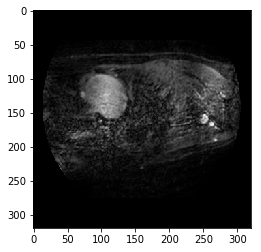

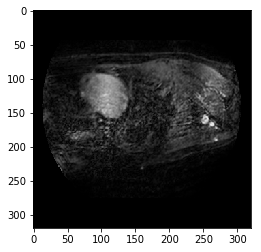

In [23]:
for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()

## Using built in Transformations

We will now see how we can use the prebuilt transformations available in `medicaltorch` in creation of data loaders. In addition to the normal torchvision dataloaders there are some specific transforms that we can see

`mt_transforms.ElasticTransform` applies both local distortion and random affine transformation. More about this transformation can be found at 
Simard, Patrice Y., David Steinkraus, and John C. Platt. ["Best practices for convolutional neural networks applied to visual document analysis." ICDAR. Vol. 3. 2003.](https://www.microsoft.com/en-us/research/publication/best-practices-for-convolutional-neural-networks-applied-to-visual-document-analysis/)

A visualization of the transformation can be also seen [here](https://evizero.github.io/Augmentor.jl/generated/mnist_elastic/#footnote-SIMARD2003)

In [30]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.ElasticTransform(alpha_range=(40.0, 60.0),
                                       sigma_range=(2.5, 4.0),
                                       p=0.3),
        mt_transforms.ToTensor()]
)

In [31]:
train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)

Now lets analyze whether we are able to see the transformation getting applied or not ?

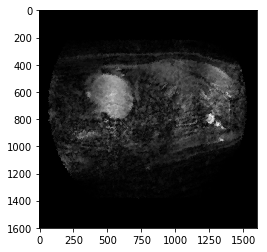

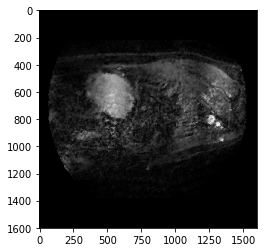

In [32]:
dataloader = DataLoader(train_dataset, batch_size=2,collate_fn=mt_datasets.mt_collate)
batch = next(iter(dataloader))
for item in batch['input']:
    plt.imshow(item.squeeze(0),cmap = 'gray')
    plt.show()